In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
df_train = pd.read_csv('../input/train.csv')
df_test = pd.read_csv('../input/test.csv')

In [3]:
df_train.shape, df_test.shape

((262144, 258), (131073, 257))

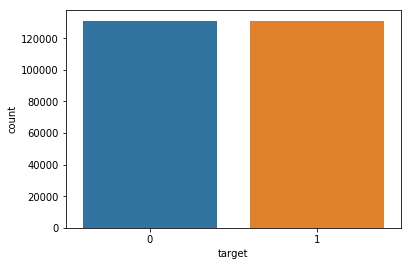

In [4]:
sns.countplot(df_train['target'])
plt.show()

In [5]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

In [36]:
split = 5
skf = StratifiedKFold(n_splits=split, random_state=0, shuffle=True)

In [39]:
random_state=1028
param = {
    "objective" : "binary",
    "metric" : "auc",
    "boosting": 'gbdt',
    "max_depth" : 8,
#     "num_leaves" : 400,
#     "min_data_in_leaf": 7,
#     "bagging_freq": 10,
#     "min_sum_heassian_in_leaf": 10,
    "learning_rate" : 0.1,
#     "bagging_fraction" : 0.8,
#     "feature_fraction" : 0.8,
#     "tree_learner": "serial",
#     "boost_from_average": "false",
    "lambda_l1" : 0.9,
    "lambda_l2" : 0.9,
#     "bagging_seed" : random_state,
    "subsample":0.8,
    "verbosity" : 1,
    "seed": random_state
}    

In [ ]:
train = df_train.iloc[:, 1:]
test = df_test.iloc[:, 1:]

oof = np.zeros(len(train))
predictions = np.zeros(len(test))

for trn_idx, val_idx in skf.split(X=train.drop(columns='target'), y=train['target']):
    
    trn_oof = lgb.Dataset(train.drop(columns='target').loc[trn_idx], label=train.loc[trn_idx, 'target'])
    val_oof = lgb.Dataset(train.drop(columns='target').loc[val_idx], label=train.loc[val_idx, 'target'])
    
    clf = lgb.train(param, trn_oof, 10000, valid_sets = [trn_oof, val_oof], early_stopping_rounds = 250, verbose_eval=500)

    oof[val_idx] = clf.predict(train.drop(columns='target').loc[val_idx], num_iteration=clf.best_iteration)
    predictions += clf.predict(test, num_iteration=clf.best_iteration)/split
    print('---'*30)
print(roc_auc_score(train['target'], oof))

In [ ]:
sub = pd.read_csv('../input/sample_submission.csv')
sub['target'] = predictions
sub.to_csv('submission_test.csv', index=False)